<a href="https://colab.research.google.com/github/unkomorimori/ai-comp-2024-2/blob/main/ai_2024_02_004_ConvNeXtLarge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data


In [2]:
import time
import threading

def keep_alive():
    while True:
        print("Keeping session alive...")
        time.sleep(600)  # 10分間隔で出力

# バックグラウンドスレッドを起動
thread = threading.Thread(target=keep_alive, daemon=True)  # daemon=True でバックグラウンド実行
thread.start()

print("バックグラウンドでセッションを維持中...")

Keeping session alive...
バックグラウンドでセッションを維持中...


In [3]:
import requests

!git clone https://github.com/unkomorimori/ai-comp-2024-2.git

Cloning into 'ai-comp-2024-2'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 23 (from 2)
Receiving objects: 100% (25/25), 219.20 MiB | 16.41 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls ai-comp-2024-2/resouces/
!unzip ai-comp-2024-2/resouces/test_images.zip
!unzip ai-comp-2024-2/resouces/train_images.zip
!cp ai-comp-2024-2/resouces/*.tsv ./

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: train_images/train_0.jpg  
  inflating: train_images/train_1.jpg  
  inflating: train_images/train_10.jpg  
  inflating: train_images/train_100.jpg  
  inflating: train_images/train_1000.jpg  
  inflating: train_images/train_1001.jpg  
  inflating: train_images/train_1002.jpg  
  inflating: train_images/train_1003.jpg  
  inflating: train_images/train_1004.jpg  
  inflating: train_images/train_1005.jpg  
  inflating: train_images/train_1006.jpg  
  inflating: train_images/train_1007.jpg  
  inflating: train_images/train_1008.jpg  
  inflating: train_images/train_1009.jpg  
  inflating: train_images/train_101.jpg  
  inflating: train_images/train_1010.jpg  
  inflating: train_images/train_1011.jpg  
  inflating: train_images/train_1012.jpg  
  inflating: train_images/train_1013.jpg  
  inflating: train_images/train_1014.jpg  
  inflating: train_images/train_1015.jpg  
  inflating: train_images/train_1016.jpg  
  inflating: train_images/train_

In [5]:
!ls
!pwd
!ls /content/train_images

ai-comp-2024-2	  sample_data	     test_images   train_master.tsv
label_master.tsv  sample_submit.tsv  train_images
/content
train_0.jpg	train_1751.jpg	train_2501.jpg	train_3252.jpg	train_4002.jpg	train_4754.jpg
train_1000.jpg	train_1752.jpg	train_2502.jpg	train_3253.jpg	train_4003.jpg	train_4755.jpg
train_1001.jpg	train_1753.jpg	train_2503.jpg	train_3254.jpg	train_4004.jpg	train_4756.jpg
train_1002.jpg	train_1754.jpg	train_2504.jpg	train_3255.jpg	train_4005.jpg	train_4757.jpg
train_1003.jpg	train_1755.jpg	train_2505.jpg	train_3256.jpg	train_4006.jpg	train_4758.jpg
train_1004.jpg	train_1756.jpg	train_2506.jpg	train_3257.jpg	train_4007.jpg	train_4759.jpg
train_1005.jpg	train_1757.jpg	train_2507.jpg	train_3258.jpg	train_4008.jpg	train_475.jpg
train_1006.jpg	train_1758.jpg	train_2508.jpg	train_3259.jpg	train_4009.jpg	train_4760.jpg
train_1007.jpg	train_1759.jpg	train_2509.jpg	train_325.jpg	train_400.jpg	train_4761.jpg
train_1008.jpg	train_175.jpg	train_250.jpg	train_3260.jpg	train_4010.jpg

In [6]:

# 3. GPUが利用可能か確認
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# 4. 混合精度学習(Mixed Precision)の設定
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
print("Mixed Precision Policy: ", tf.keras.mixed_precision.global_policy())

# 5. ファイルパスの設定
base_dir = "./"



Num GPUs Available:  1
Mixed Precision Policy:  <DTypePolicy "mixed_float16">


In [7]:

# 6. 必要なライブラリのインポート
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.convnext import ConvNeXtLarge, preprocess_input as preprocess_convnext
from tensorflow.keras.activations import swish


# 7. データの準備（解凍＆ファイルコピー）
if not os.path.exists("train_images"):
    os.system(f"unzip -q '{base_dir}/train_images.zip'")
    os.system(f"unzip -q '{base_dir}/test_images.zip'")
    !cp "{base_dir}/label_master.tsv" .
    !cp "{base_dir}/sample_submit.tsv" .
    !cp "{base_dir}/train_master.tsv" .

train_master = pd.read_csv('train_master.tsv', sep='\t')
label_master = pd.read_csv('label_master.tsv', sep='\t')
train_master['label_id'] = train_master['label_id'].astype(str)

# =========================================================
# 8. データ前処理＆学習・検証用ジェネレータの作成
#    （ラベル毎にバランス良くデータを分割する）
# =========================================================
from sklearn.model_selection import train_test_split

def create_generators(preprocess_func, batch_size=50, target_size=(224, 224), test_size=0.2):
    """
    画像の基本的な前処理ジェネレータ（データ拡張あり）
    ラベルが均等になるように Stratified 分割でトレイン・バリデーションを作成
    """
    # ラベル分布が均等になるように分割
    train_df, val_df = train_test_split(
        train_master,
        test_size=test_size,
        random_state=42,
        stratify=train_master['label_id']
    )

    # 学習用のImageDataGenerator（データ拡張を付与）
    datagen_train = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        preprocessing_function=preprocess_func
    )

    # バリデーション用のImageDataGenerator（データ拡張なし）
    datagen_val = ImageDataGenerator(
        preprocessing_function=preprocess_func
    )

    train_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory="train_images",
        x_col='file_name',
        y_col='label_id',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    val_generator = datagen_val.flow_from_dataframe(
        dataframe=val_df,
        directory="train_images",
        x_col='file_name',
        y_col='label_id',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )

    return train_generator, val_generator

# =========================================================
# 9. モデル構築（ConvNeXtLarge + カスタム分類ヘッド）
#    （Swish活性化, BatchNormalization, Dropout採用）
# =========================================================

def build_convnext_model(input_shape=(224,224,3), num_classes=10, train_base=False):
    """
    ConvNeXtLarge をベースとした転移学習モデルの構築
    train_base=Falseならベースは凍結、Trueならファインチューニング可能
    """
    base_model = ConvNeXtLarge(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    # ベースモデルの凍結設定
    for layer in base_model.layers:
        layer.trainable = train_base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation=swish)(x)  # Swish活性化
    x = Dropout(0.3)(x)
    x = Dense(512, activation=swish)(x)
    x = Dropout(0.3)(x)
    # 出力層はfloat32にキャスト（Mixed Precision環境下で安定動作のため）
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# =========================================================
# 10. 損失関数（Focal Loss導入）
# =========================================================

import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    マルチクラス分類用 Focal Loss の定義
    """
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        focal_term = alpha * K.pow((1 - y_pred), gamma) * cross_entropy
        return K.mean(K.sum(focal_term, axis=1))
    return focal_loss_fixed

# =========================================================
# 11. モデルコンパイル・学習
# =========================================================

# ジェネレータ作成（ConvNeXt用の前処理関数を指定）
train_gen, val_gen = create_generators(
    preprocess_func=preprocess_convnext,
    batch_size=50,
    target_size=(224, 224),
    test_size=0.2
)

# モデル構築（初期学習時はベースは凍結）
model = build_convnext_model(
    input_shape=(224,224,3),
    num_classes=10,
    train_base=False
)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-5  # 適宜調整
    ),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)



Found 4000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
785596384/785596384 ━━━━━━━━━━━━━━━━━━━━ 37s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 92s 685ms/step - accuracy: 0.6960 - loss: 0.1697 - val_accuracy: 0.9880 - val_loss: 0.0283 - learning_rate: 1.0000e-04
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 577ms/step - accuracy: 0.9778 - loss: 0.0102 - val_accuracy: 0.9880 - val_loss: 0.0103 - learning_rate: 1.0000e-04
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 581ms/step - accuracy: 0.9876 - loss: 0.0053 - val_accuracy: 0.9880 - val_loss: 0.0061 - learning_rate: 1.0000e-04
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 577ms/step - accuracy: 0.9901 - loss: 0.0036 - val_accuracy: 0.9840 - val_loss: 0.0050 - learning_rate: 1.0000e-04
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 579ms/step - accuracy: 0.9926 - loss: 0.0029 - val_accuracy: 0.9850 - val_loss: 0.0044 - learning_rate: 1.0000e-04
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 578ms/step - accuracy: 0.9947 - loss: 0.0018 - val_accuracy: 0.9880 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 526ms/step - acc

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_f

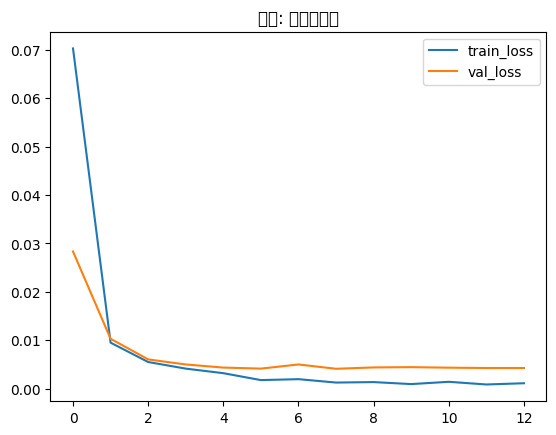

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


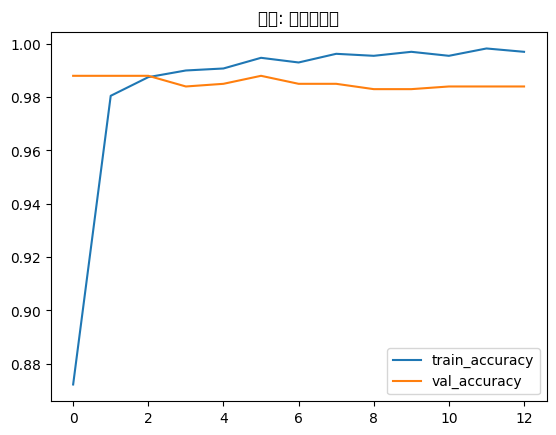

In [8]:

# コールバック設定
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model_convnextlarge.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
]

# 学習開始
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size,
    epochs=50,
    callbacks=callbacks
)

# 学習過程の可視化（損失）
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('学習: 損失の推移')
plt.legend()
plt.show()

# 学習過程の可視化（精度）
plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('学習: 精度の推移')
plt.legend()
plt.show()


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 87s 722ms/step - accuracy: 0.9943 - loss: 0.0014 - val_accuracy: 0.9860 - val_loss: 0.0040 - learning_rate: 1.0000e-05
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 536ms/step - accuracy: 0.9962 - loss: 0.0013 - val_accuracy: 0.9870 - val_loss: 0.0041 - learning_rate: 1.0000e-05
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 613ms/step - accuracy: 0.9976 - loss: 9.8562e-04 - val_accuracy: 0.9870 - val_loss: 0.0039 - learning_rate: 1.0000e-05
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 536ms/step - accuracy: 0.9963 - loss: 0.0012 - val_accuracy: 0.9870 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 611ms/step - accuracy: 0.9985 - loss: 5.3090e-04 - val_accuracy: 0.9870 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 529ms/step - accuracy: 0.9957 - loss: 0.0015 - val_accuracy: 0.9870 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 622ms/st

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12449 (\N{KATAKANA LETTER SMALL A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12481 (\N{KATAKANA LETTER TI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

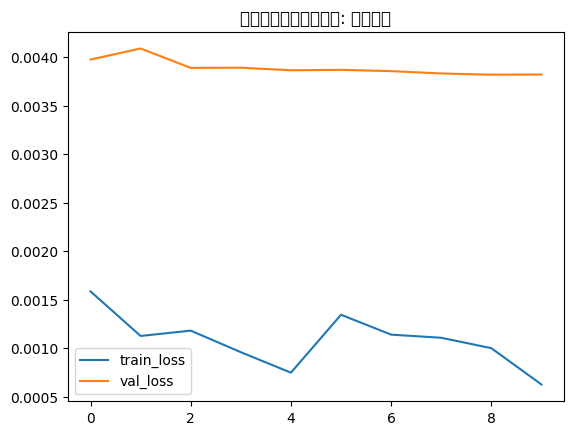

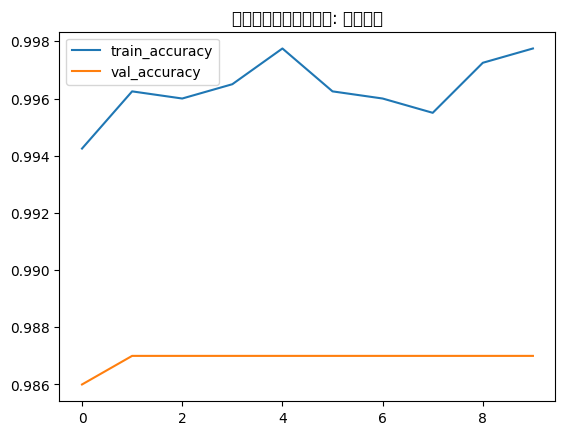

In [9]:

# ---------------------------------------------------------
# 12. ファインチューニング（最後の20層を解凍）
# ---------------------------------------------------------
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=1e-5,
        weight_decay=1e-6  # 適宜調整
    ),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)

fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model_convnextlarge_finetuned.keras', monitor='val_loss', save_best_only=True),
    # 学習率スケジューラ
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
]

history_fine = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size,
    #epochs=30,
    epochs=10,
    callbacks=fine_tune_callbacks
)

plt.figure()
plt.plot(history_fine.history['loss'], label='train_loss')
plt.plot(history_fine.history['val_loss'], label='val_loss')
plt.title('ファインチューニング: 損失推移')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_fine.history['accuracy'], label='train_accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val_accuracy')
plt.title('ファインチューニング: 精度推移')
plt.legend()
plt.show()




20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step


<ipython-input-10-30b1a667cbb5>:32: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-30b1a667cbb5>:32: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-30b1a667cbb5>:32: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-30b1a667cbb5>:32: UserWarning: Glyph 12505 (\N{KATAKANA LETTER BE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-30b1a667cbb5>:32: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-30b1a667cbb5>:32: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-30b1a667cbb5>:32: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  

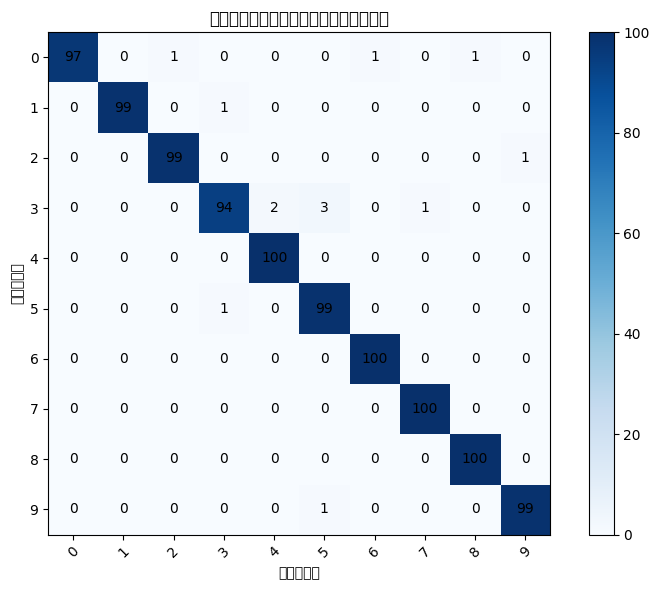

In [10]:

# =========================================================
# ★ バリデーションデータで予測し、ヒートマップ（混同行列）を表示する処理
# =========================================================

!pip install scikit-learn
from sklearn.metrics import confusion_matrix

val_gen.reset()  # 念のためジェネレータを最初の状態に戻す
val_predictions = model.predict(val_gen, steps=len(val_gen), verbose=1)
val_predicted_classes = np.argmax(val_predictions, axis=1)

true_classes = val_gen.classes
cm = confusion_matrix(true_classes, val_predicted_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('バリデーションデータにおける混同行列')
plt.colorbar()

num_classes = 10  # クラス数
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [str(i) for i in range(num_classes)], rotation=45)
plt.yticks(tick_marks, [str(i) for i in range(num_classes)])

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(cm[i, j]),
                 ha='center', va='center', color='black')

plt.ylabel('正解ラベル')
plt.xlabel('予測ラベル')
plt.tight_layout()
plt.show()

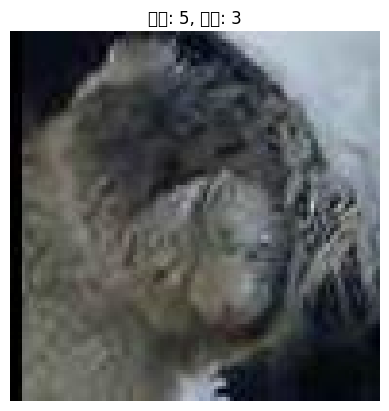

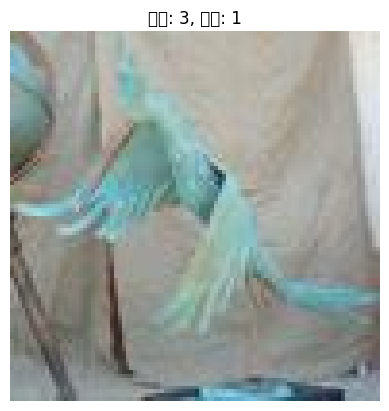

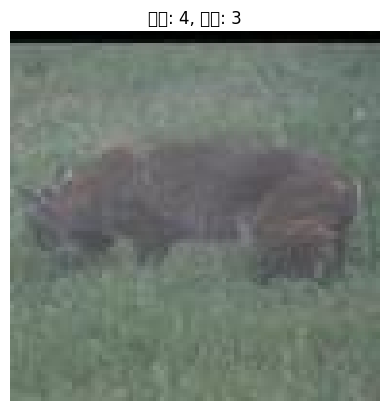

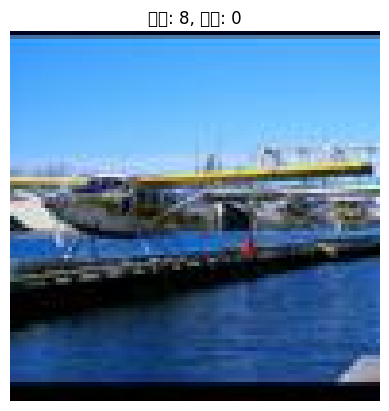

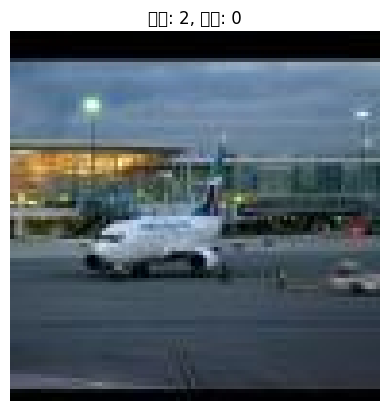

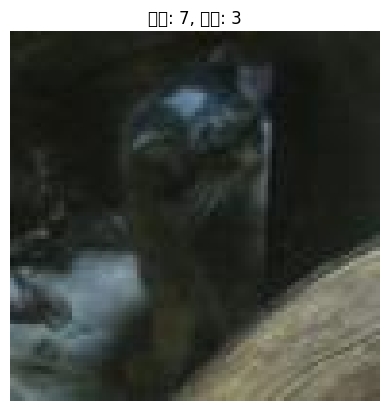

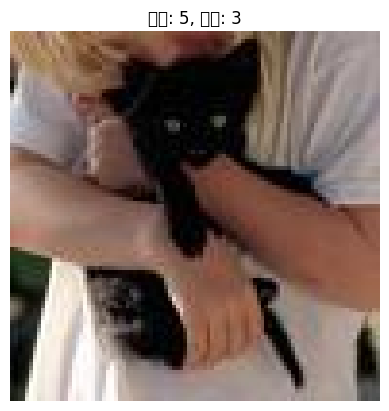

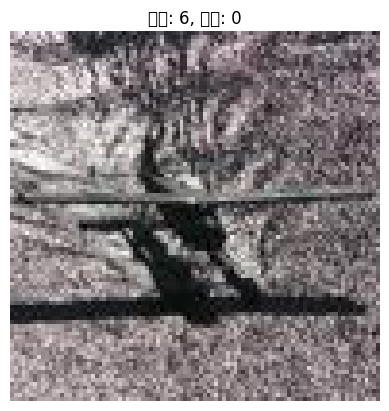

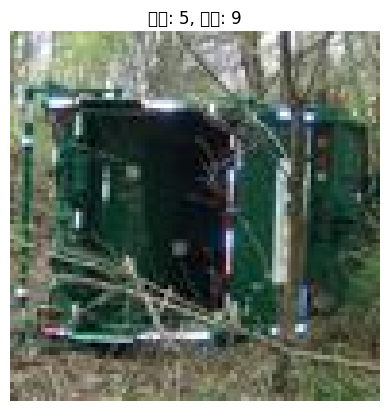

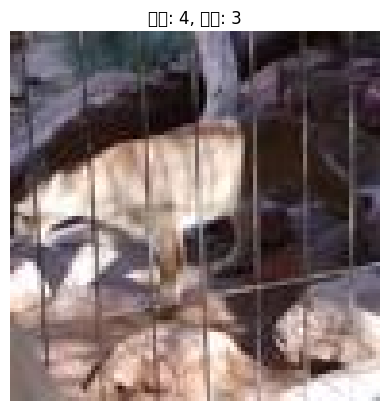

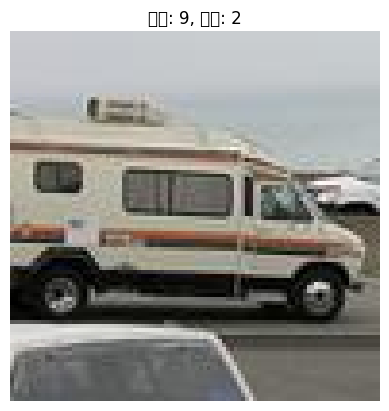

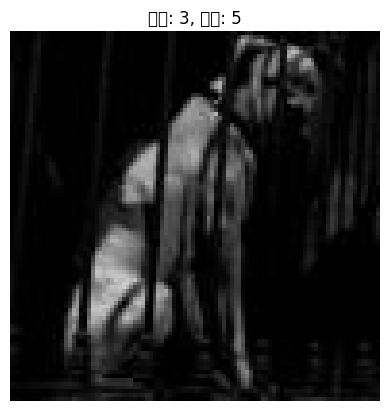

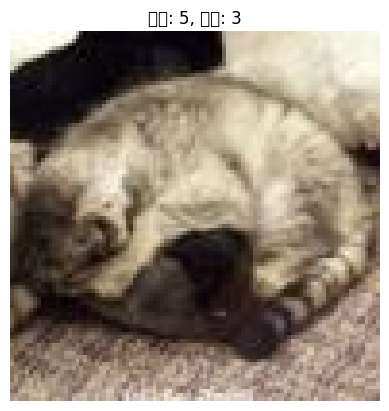

In [11]:
# 誤分類画像を可視化して原因分析
import matplotlib.pyplot as plt

misclassified_idx = np.where(val_predicted_classes != true_classes)[0]
misclassified_images = val_gen.filepaths  # ファイルパス一覧（ImageDataGenerator使用時）

for idx in misclassified_idx[:30]:  # 最初の30枚だけ
    img = plt.imread(misclassified_images[idx])
    plt.imshow(img)
    plt.title(f"予測: {val_predicted_classes[idx]}, 正解: {true_classes[idx]}")
    plt.axis('off')
    plt.show()

In [23]:
# =========================================================
# 13. テストデータでの推論と提出ファイルの作成
# =========================================================
test_filenames = os.listdir("test_images")
test_df = pd.DataFrame({'file_name': test_filenames})

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_convnext
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="test_images",
    x_col='file_name',
    y_col=None,
    target_size=(224,224),
    batch_size=50,
    class_mode=None,
    shuffle=False
)

predictions = model.predict(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

predicted_classes = np.argmax(predictions, axis=1)

submission = pd.DataFrame({
    'file_name': test_filenames,
    'label_id': predicted_classes
})

submission['file_num'] = submission['file_name'].str.extract(r'(\d+)').astype(int)
submission = submission.sort_values(by='file_num').drop(columns='file_num')

output_filename = f'{base_dir}/submission_convnextlarge_0324_r0.tsv'
submission.to_csv(output_filename, sep='\t', index=False, header=False)
print(f"提出用ファイル {output_filename} を作成しました。")

Found 8001 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 64/161 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/stepKeeping session alive...
161/161 ━━━━━━━━━━━━━━━━━━━━ 36s 223ms/step
提出用ファイル .//submission_convnextlarge_0324_r0.tsv を作成しました。


In [13]:
!ls

ai-comp-2024-2				  sample_data				train_images
best_model_convnextlarge_finetuned.keras  sample_submit.tsv			train_master.tsv
best_model_convnextlarge.keras		  submission_convnextlarge_0324_r0.tsv
label_master.tsv			  test_images


In [14]:
from google.colab import drive
drive.mount('/content/drive')

submission_filename = "submission_convnextlarge_0324_r0.tsv"

import shutil

src_path = f"/content/{submission_filename}"
dst_path = "/content/drive/MyDrive/Colab Notebooks/"

shutil.copy(src_path, dst_path)

ValueError: mount failed